# Tutorial

### An open RNA-Seq data analysis pipeline tutorial

_Michael Mayhew_ and _Dina Machuve_

Reference: Wang, Z. and Ma'ayan, A. (2016) __An open RNA-Seq data analysis pipeline tutorial with an example of reprocessing data from a recent Zika virus study__ F1000Research 2016, :1574 ([doi:5 10.12688/f1000research.9110.1](http://dx.doi.org/10.12688/f1000research.9110.1))

*Data Science Africa 2019 ([DSA2019](http://www.datascienceafrica.org/dsa2019addis/)), Addis* 

_04<sup>th</sup> June, 2019_

---
__Outline__

1. [Overview of the Pipeline](#out1)
2. [Workflow and Tools](#out2)
     * [Raw files pre-processing](#out2)
     * [Alignment](#out22)
     * [Analysis](#out23)
     * [Visualization: PCA and Clustergrammer](#out24)
3. [Differential Expression](#out3)
4. [Further Analysis](#out4)
4. [References](#out5)
---

<a id='out1'></a>
### 1. Overview of the RNA-Seq Analysis Pipeline

This is a tutorial for performing a standard RNA-Seq pipeline. The case study is the devastating Zika virus (ZIKV) infection which affects new-born babies and is transmitted from pregnant mothers infected with the virus.
The original IPython notebook and Docker image are freely available at [[1]](#ref1) and [[2]](#ref2).


<img src="img/pipelinernaseq.svg" alt="drawing" width="2000" height="2000"/>

*Source: http://bioinfo.vanderbilt.edu/vangard/services-rnaseq.html and http://maayanlab.github.io/Zika-RNAseq-Pipeline/flowchart.html*

In [1]:
import os
import numpy as np
import pandas as pd

Below we assign some global variables that will be used across the rest of the notebook.    
*Please change these variables accordingly if you intend to use this for other studies.*

In [2]:
#The working directory of SRA files downloaded by SRA toolkit
os.environ['SRA_ORGPATH']= '/home/dmachuve/ncbi/public/sra/'
# The working directory to store all the sequencing data, will be created if not exists
os.environ['WORKDIR'] = '/home/dmachuve/Dropbox/DSA/DSA2019/bioinfoDSA/data/Zika/'
# The directory for the reference genome
os.environ['GENOMEDIR'] = '/home/dmachuve/Dropbox/DSA/DSA2019/bioinfoDSA/genomes/'

In [11]:
#copy the downloaded SRA files to WORKDIR
#This bash script is commented out because we don't want to copy rhe SRA files every time.
!mkdir -p $WORKDIR
!cp $SRA_ORGPATH/* $WORKDIR

^C


In [3]:
## Examine the copied SRA files previously downloaded
!ls -lh $WORKDIR/*.sra

-rw-r--r-- 1 dmachuve dmachuve 465M Mei 23 09:51 /home/dmachuve/Dropbox/DSA/DSA2019/bioinfoDSA/data/Zika//SRR3191542.sra
-rw-r--r-- 1 dmachuve dmachuve 444M Mei 23 09:51 /home/dmachuve/Dropbox/DSA/DSA2019/bioinfoDSA/data/Zika//SRR3191543.sra
-rw-r--r-- 1 dmachuve dmachuve 430M Mei 23 09:51 /home/dmachuve/Dropbox/DSA/DSA2019/bioinfoDSA/data/Zika//SRR3191544.sra
-rw-r--r-- 1 dmachuve dmachuve 446M Mei 23 09:51 /home/dmachuve/Dropbox/DSA/DSA2019/bioinfoDSA/data/Zika//SRR3191545.sra
-rw-r--r-- 1 dmachuve dmachuve 2.4G Mei  6 16:11 /home/dmachuve/Dropbox/DSA/DSA2019/bioinfoDSA/data/Zika//SRR3194428.sra
-rw-r--r-- 1 dmachuve dmachuve 3.1G Mei  4 03:03 /home/dmachuve/Dropbox/DSA/DSA2019/bioinfoDSA/data/Zika//SRR3194429.sra
-rw-r--r-- 1 dmachuve dmachuve 2.5G Mei 23 09:54 /home/dmachuve/Dropbox/DSA/DSA2019/bioinfoDSA/data/Zika//SRR3194430.sra
-rw-r--r-- 1 dmachuve dmachuve 2.2G Mei 23 09:56 /home/dmachuve/Dropbox/DSA/DSA2019/bioinfoDSA/data/Zika//SRR3194431.sra


<a id='out2'></a>
### 2. Workflow and Tools
#### 2.1 The downloaded SRA files are next processed by following these steps:
1. `fastq-dump`<sup>[3](#ref3)</sup> in the SRA-toolkit to generate .fastq files
2. `FastQC`<sup>[4](#ref4)</sup> to perform Quality Controls and generate QC report for the input RNA-seq data
3. `STAR`<sup>[5](#ref5)</sup> for the read alignment
4. `featureCounts`<sup>[6](#ref6)</sup> for assigning reads to genes
5. `edgeR` Bioconductor package<sup>[7](#ref7)</sup> were used to compute CPM and RPKM
---
* Step 1 is processed by this bash script [`analyze_sra.sh`](https://github.com/MaayanLab/Zika-RNAseq-Pipeline/blob/master/analyze_sra.sh). This bash script can take command line arguments specifying the location of the raw SRA data files eference genome and working directory for the SRA files.
* Steps 2-4 are processed by this bash script [`analyze_sra2.sh`](https://github.com/MaayanLab/Zika-RNAseq-Pipeline/blob/master/analyze_sra2.sh). This bash script can take command line arguments specifying the location of the reference genome and working directory for the SRA files.
* Step 5 on was done in R
* __Caution__: These steps were done on a workstation machine with __218GB RAM__ and Ubuntu 19.04 OS for __5 hours__. It will not work on a normal laptop
---


In [4]:
!bash analyze_sra.sh -h

Usage: ./analyze_sra.sh -g <GENOME> -w <WORKDIR>
Options:
  --skip-qc: Skip fastQC steps for the fastq files
  -t, --cpus: Number of CPUs to use, default to 8


We run the bash script by specifying the working directory and the genome directory and pipe the log into a `analyze_sra.log` file


In [10]:
!bash analyze_sra.sh -w $WORKDIR -g $GENOMEDIR | tee analyze_sra.log

Number of CPUs to be used: 8
GENOME=/home/cocse/Documents/python/bioinfoDSA/genomes
WORKDIR=/home/cocse/Documents/python/bioinfoDSA/data/Zika
STAR index does not exist, building STAR index
analyze_sra.sh: line 93: STAR: command not found
Dumping .sra files to .fastq.gz files
SRR3191543.sra is detected as paired-end sequencing reads
SRR3191545.sra is detected as paired-end sequencing reads
SRR3191544.sra is detected as paired-end sequencing reads
SRR3194428.sra is detected as single-end sequencing reads
SRR3191542.sra is detected as paired-end sequencing reads
SRR3194430.sra is detected as single-end sequencing reads
SRR3194429.sra is detected as single-end sequencing reads
SRR3194431.sra is detected as single-end sequencing reads
Read 7391076 spots for SRR3191543.sra
Written 7391076 spots for SRR3191543.sra
Read 7361527 spots for SRR3191544.sra
Written 7361527 spots for SRR3191544.sra
Read 7621347 spots for SRR3191545.sra
Written 7621347 spots for SRR3191545.sra
Read 7927777 spots for 

<a id='out22'></a>
#### 2.2 Alignment
__Reference genome download__
The hg19 build of the human genome was downloaded from [Illumina's](https://support.illumina.com/sequencing/sequencing_software/igenome.html) site.

__Read alignment__
We run the bash script `analyze_sra2.sh` by specifying the working directory and the genome directory and pipe the log into a `analyze_sra2.log` file. 
Tools used were:
* `FastQC` 
* `STAR`
* `featureCounts`

__Caution__: This is done on a workstation with `218GB RAM`

In [ ]:
!bash analyze_sra2.sh -w $WORKDIR -g $GENOMEDIR | tee analyze_sra2.log

Number of CPUs to be used: 8
STAR index does not exist, building STAR index
May 27 16:58:04 ..... started STAR run
May 27 16:58:04 ... starting to generate Genome files
May 27 16:59:58 ... starting to sort Suffix Array. This may take a long time...
May 27 17:00:28 ... sorting Suffix Array chunks and saving them to disk...
May 27 18:09:21 ... loading chunks from disk, packing SA...
May 27 18:12:37 ... finished generating suffix array
May 27 18:12:37 ... generating Suffix Array index
May 27 18:23:47 ... completed Suffix Array index
May 27 18:23:47 ..... processing annotations GTF
May 27 18:23:54 ..... inserting junctions into the genome indices
May 27 18:31:25 ... writing Genome to disk ...
May 27 18:31:32 ... writing Suffix Array to disk ...
May 27 18:32:18 ... writing SAindex to disk
May 27 18:32:23 ..... finished successfully
Started to align reads to the genome and assemble transcriptome
Performing FastQC for SRR3194428
Started analysis of SRR3194428.fastq.gz
Approx 5% complete for S

||    Features : 505974                                                       ||
||    Meta-features : 26364                                                   ||
||    Chromosomes/contigs : 51                                                ||
||                                                                            ||
|| Process BAM file SRR3194429Aligned.out.bam...                              ||
||    Single-end reads are included.                                          ||
||    Assign alignments to features...                                        ||
||    Total alignments : 101847744                                            ||
||    Successfully assigned alignments : 63512536 (62.4%)                     ||
||    Running time : 0.80 minutes                                             ||
||                                                                            ||
||                                                                            ||
|| Summary of counting resul

In [5]:
!bash analyze_sra2.sh -w $WORKDIR -g $GENOMEDIR | tee analyze_sra2.log

Number of CPUs to be used: 8
Started to align reads to the genome and assemble transcriptome
Performing FastQC for SRR3194428
Started analysis of SRR3194428.fastq.gz
Approx 5% complete for SRR3194428.fastq.gz
Approx 10% complete for SRR3194428.fastq.gz
Approx 15% complete for SRR3194428.fastq.gz
Approx 20% complete for SRR3194428.fastq.gz
Approx 25% complete for SRR3194428.fastq.gz
Approx 30% complete for SRR3194428.fastq.gz
Approx 35% complete for SRR3194428.fastq.gz
Approx 40% complete for SRR3194428.fastq.gz
Approx 45% complete for SRR3194428.fastq.gz
Approx 50% complete for SRR3194428.fastq.gz
Approx 55% complete for SRR3194428.fastq.gz
Approx 60% complete for SRR3194428.fastq.gz
Approx 65% complete for SRR3194428.fastq.gz
Approx 70% complete for SRR3194428.fastq.gz
Approx 75% complete for SRR3194428.fastq.gz
Approx 80% complete for SRR3194428.fastq.gz
Approx 85% complete for SRR3194428.fastq.gz
Approx 90% complete for SRR3194428.fastq.gz
Approx 95% complete for SRR3194428.fastq.gz

||    Features : 505974                                                       ||
||    Meta-features : 26364                                                   ||
||    Chromosomes/contigs : 51                                                ||
||                                                                            ||
|| Process BAM file SRR3194429Aligned.out.bam...                              ||
||    Single-end reads are included.                                          ||
||    Assign alignments to features...                                        ||
||    Total alignments : 101847744                                            ||
||    Successfully assigned alignments : 63512536 (62.4%)                     ||
||    Running time : 0.44 minutes                                             ||
||                                                                            ||
||                                                                            ||
|| Summary of counting resul

||    Features : 505974                                                       ||
||    Meta-features : 26364                                                   ||
||    Chromosomes/contigs : 51                                                ||
||                                                                            ||
|| Process BAM file SRR3194431Aligned.out.bam...                              ||
||    Single-end reads are included.                                          ||
||    Assign alignments to features...                                        ||
||    Total alignments : 70338932                                             ||
||    Successfully assigned alignments : 43547129 (61.9%)                     ||
||    Running time : 0.31 minutes                                             ||
||                                                                            ||
||                                                                            ||
|| Summary of counting resul

Approx 40% complete for SRR3191543_1.fastq.gz
Approx 45% complete for SRR3191543_1.fastq.gz
Approx 50% complete for SRR3191543_1.fastq.gz
Approx 55% complete for SRR3191543_1.fastq.gz
Approx 60% complete for SRR3191543_1.fastq.gz
Approx 65% complete for SRR3191543_1.fastq.gz
Approx 70% complete for SRR3191543_1.fastq.gz
Approx 75% complete for SRR3191543_1.fastq.gz
Approx 80% complete for SRR3191543_1.fastq.gz
Approx 85% complete for SRR3191543_1.fastq.gz
Approx 90% complete for SRR3191543_1.fastq.gz
Approx 95% complete for SRR3191543_1.fastq.gz
Analysis complete for SRR3191543_1.fastq.gz
Started analysis of SRR3191543_2.fastq.gz
Approx 5% complete for SRR3191543_2.fastq.gz
Approx 10% complete for SRR3191543_2.fastq.gz
Approx 15% complete for SRR3191543_2.fastq.gz
Approx 20% complete for SRR3191543_2.fastq.gz
Approx 25% complete for SRR3191543_2.fastq.gz
Approx 30% complete for SRR3191543_2.fastq.gz
Approx 35% complete for SRR3191543_2.fastq.gz
Approx 40% complete for SRR3191543_2.fast


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v1.6.4

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 1 BAM file                                       ||
||                           P SRR3191544Aligned.out.bam                      ||
||                                                                            ||
||             Output file : SRR3191544.count.txt                             ||
||                 Summary : SRR3191544.count.txt.summary        

||    Features : 505974                                                       ||
||    Meta-features : 26364                                                   ||
||    Chromosomes/contigs : 51                                                ||
||                                                                            ||
|| Process BAM file SRR3191545Aligned.out.bam...                              ||
||    Paired-end reads are included.                                          ||
||    Assign alignments to features...                                        ||
||    Total alignments : 15297987                                             ||
||    Successfully assigned alignments : 10371971 (67.8%)                     ||
||    Running time : 0.07 minutes                                             ||
||                                                                            ||
||                                                                            ||
|| Summary of counting resul


Step 5 is done with this R script [`normalize.R`](https://github.com/MaayanLab/Zika-RNAseq-Pipeline/blob/master/normalize.R)

In [8]:
!Rscript normalize.R $WORKDIR

Setting WORKDIR to: /home/cocse/Documents/python/bioinfoDSA/data/Zika/ 
Loading required package: limma
Finished reading featureCount into data.frame with shape:  26364 9 

CPM matrix file written to "repCpmMatrix_featureCounts.csv"
RPKM matrix written to "repRpkmMatrix_featureCounts.csv"

<a id='out23'></a>
#### 2.3 Analysis
* QC reports
* Alignment Stats

In [1]:
## We can examine the QC reports from the FastQC program to evaluate the quality of the data
from IPython.display import FileLinks
FileLinks('data/Zika/fastQC_output/', included_suffixes=['.html'])

data/Zika/fastQC_output/
  SRR3191543_1_fastqc.html
  SRR3194430_fastqc.html
  SRR3191544_1_fastqc.html
  SRR3194431_fastqc.html
  SRR3194428_fastqc.html
  SRR3191542_1_fastqc.html
  SRR3191545_1_fastqc.html
  SRR3191543_2_fastqc.html
  SRR3191542_2_fastqc.html
  SRR3191544_2_fastqc.html
  SRR3191545_2_fastqc.html
  SRR3194429_fastqc.html

In [3]:
## Check the alignment stats
## This will output the first 10 lines of all summary files from the featureCounts folder
!head $WORKDIR/featureCount_output/*.summary

==> /home/dmachuve/Dropbox/DSA/DSA2019/bioinfoDSA/data/Zika//featureCount_output/SRR3191542.count.txt.summary <==
Status	/home/cocse/Documents/python/bioinfoDSA//data/Zika/star_output/SRR3191542Aligned.out.bam
Assigned	10893451
Unassigned_Unmapped	0
Unassigned_MappingQuality	0
Unassigned_Chimera	0
Unassigned_FragmentLength	0
Unassigned_Duplicate	0
Unassigned_MultiMapping	1316064
Unassigned_Secondary	0
Unassigned_NonSplit	0

==> /home/dmachuve/Dropbox/DSA/DSA2019/bioinfoDSA/data/Zika//featureCount_output/SRR3191543.count.txt.summary <==
Status	/home/cocse/Documents/python/bioinfoDSA//data/Zika/star_output/SRR3191543Aligned.out.bam
Assigned	10198068
Unassigned_Unmapped	0
Unassigned_MappingQuality	0
Unassigned_Chimera	0
Unassigned_FragmentLength	0
Unassigned_Duplicate	0
Unassigned_MultiMapping	1229850
Unassigned_Secondary	0
Unassigned_NonSplit	0

==> /home/dmachuve/Dropbox/DSA/DSA2019/bioinfoDSA/data/Zika//featureCount_output/SRR3191544.count.txt.summary <==
Status	/home/cocse/Documents/p

After you completed successfully the above steps, you can start to analyze the processed expression matrix of gene expression in Python

In [4]:
## Load the expression matrix
expr_df = pd.read_csv('data/Zika/repCpmMatrix_featureCounts.csv')
expr_df = expr_df.set_index(expr_df.columns[0])
expr_df.head()

SRR3191542  SRR3191543  SRR3191544  SRR3191545  SRR3194428  \
Unnamed: 0                                                               
DDX11L1       0.000000    0.000000    0.198922    0.000000    0.000000   
WASH7P       16.707286   18.042633   17.007867   23.139286    2.482738   
MIR6859-3     0.000000    0.000000    0.000000    0.000000    0.000000   
MIR6859-2     0.000000    0.000000    0.000000    0.000000    0.000000   
MIR6859-4     0.000000    0.000000    0.000000    0.000000    0.000000   

            SRR3194429  SRR3194430  SRR3194431  
Unnamed: 0                                      
DDX11L1       0.000000    0.020025    0.000000  
WASH7P        2.897066    2.182745    2.388217  
MIR6859-3     0.000000    0.000000    0.000000  
MIR6859-2     0.000000    0.000000    0.000000  
MIR6859-4     0.000000    0.000000    0.000000

In [5]:
print(expr_df.shape)

(26364, 8)


In [5]:
## Filter out non-expressed genes
expr_df = expr_df.loc[expr_df.sum(axis=1) > 0, :]
print(expr_df.shape)

## Filter out lowly expressed genes
mask_low_vals = (expr_df > 0.3).sum(axis=1) > 2
expr_df = expr_df.loc[mask_low_vals, :]

print(expr_df.shape)


(22658, 8)
(16403, 8)


Obtain more metadata about the samples by clicking on the `RunInfo Table` button on the SRP page available in this URL [http://www.ncbi.nlm.nih.gov/Traces/study/?acc=SRP070895](http://www.ncbi.nlm.nih.gov/Traces/study/?acc=SRP070895). Clicking on this button downloads a spreadsheet with additional metadata. Next read this file and extract the relavant variables from it.

In [6]:
meta_df = pd.read_csv('data/Zika/SraRunTable.txt', sep='\t').set_index('Run')
print(meta_df.shape)
# re-order the index to make it the same with expr_df
meta_df = meta_df.loc[expr_df.columns]
meta_df

(8, 27)


AvgSpotLen     BioSample   DATASTORE_filetype DATASTORE_provider  \
SRR3191542         150  SAMN04517925                  sra            sra-sos   
SRR3191543         150  SAMN04517926                  sra            sra-sos   
SRR3191544         150  SAMN04517927                  sra            sra-sos   
SRR3191545         150  SAMN04517928                  sra            sra-sos   
SRR3194428          75  SAMN04521221  sra unknown_contigs               ncbi   
SRR3194429          75  SAMN04521222  sra unknown_contigs       ncbi sra-sos   
SRR3194430          75  SAMN04521223  sra unknown_contigs               ncbi   
SRR3194431          75  SAMN04521224  sra unknown_contigs       ncbi sra-sos   

           DATASTORE_region  Experiment      Instrument LibraryLayout  \
SRR3191542   sra-sos.public  SRX1602854  Illumina MiSeq        PAIRED   
SRR3191543   sra-sos.public  SRX1602855  Illumina MiSeq        PAIRED   
SRR3191544   sra-sos.public  SRX1602856  Illumina MiSeq        PAIRED   
SRR3191545   sra-sos.public  SRX1602857  Illumina MiSeq        PAIRED   
SRR3194428              NaN  SRX1605077     NextSeq 500        SINGLE   
SRR3194429   sra-sos.public  SRX1605078     NextSeq 500        SINGLE   
SRR3194430              NaN  SRX1605079     NextSeq 500        SINGLE   
SRR3194431   sra-sos.public  SRX1605080     NextSeq 500        SINGLE   

              LoadDate  MBases              ...                Consent  \
SRR3191542  2016-02-26    1141              ...                 public   
SRR3191543  2016-02-26    1063              ...                 public   
SRR3191544  2016-02-26    1059              ...                 public   
SRR3191545  2016-02-26    1095              ...                 public   
SRR3194428  2016-02-29    5248              ...                 public   
SRR3194429  2016-02-29    6806              ...                 public   
SRR3194430  2016-02-29    5481              ...                 public   
SRR3194431  2016-02-29    4776              ...                 public   

           InsertSize LibrarySelection   LibrarySource      Organism  \
SRR3191542          0             cDNA  TRANSCRIPTOMIC  Homo sapiens   
SRR3191543          0             cDNA  TRANSCRIPTOMIC  Homo sapiens   
SRR3191544          0             cDNA  TRANSCRIPTOMIC  Homo sapiens   
SRR3191545          0             cDNA  TRANSCRIPTOMIC  Homo sapiens   
SRR3194428          0             cDNA  TRANSCRIPTOMIC  Homo sapiens   
SRR3194429          0             cDNA  TRANSCRIPTOMIC  Homo sapiens   
SRR3194430          0             cDNA  TRANSCRIPTOMIC  Homo sapiens   
SRR3194431          0             cDNA  TRANSCRIPTOMIC  Homo sapiens   

            Platform ReleaseDate  SRA_Study                cell_type  \
SRR3191542  ILLUMINA  2016-03-04  SRP070895  Neural Progenitor cells   
SRR3191543  ILLUMINA  2016-03-04  SRP070895  Neural Progenitor cells   
SRR3191544  ILLUMINA  2016-03-04  SRP070895  Neural Progenitor cells   
SRR3191545  ILLUMINA  2016-03-04  SRP070895  Neural Progenitor cells   
SRR3194428  ILLUMINA  2016-03-04  SRP070895  Neural Progenitor cells   
SRR3194429  ILLUMINA  2016-03-04  SRP070895  Neural Progenitor cells   
SRR3194430  ILLUMINA  2016-03-04  SRP070895  Neural Progenitor cells   
SRR3194431  ILLUMINA  2016-03-04  SRP070895  Neural Progenitor cells   

                              source_name  
SRR3191542  human Neural Progenitor cells  
SRR3191543  human Neural Progenitor cells  
SRR3191544  human Neural Progenitor cells  
SRR3191545  human Neural Progenitor cells  
SRR3194428  human Neural Progenitor cells  
SRR3194429  human Neural Progenitor cells  
SRR3194430  human Neural Progenitor cells  
SRR3194431  human Neural Progenitor cells  

[8 rows x 27 columns]

In [13]:
meta_df.columns

Index(['AvgSpotLen', 'BioSample', 'DATASTORE_filetype', 'DATASTORE_provider',
       'DATASTORE_region', 'Experiment', 'Instrument', 'LibraryLayout',
       'LoadDate', 'MBases', 'MBytes', 'SRA_Sample', 'Sample_Name',
       'infection_status', 'Assay_Type', 'BioProject', 'Center_Name',
       'Consent', 'InsertSize', 'LibrarySelection', 'LibrarySource',
       'Organism', 'Platform', 'ReleaseDate', 'SRA_Study', 'cell_type',
       'source_name'],
      dtype='object')

<a id='out24'></a>
#### 2.4 Visualization
Now we have everything setup, the first thing to do is to generate PCA plots to observe whether the samples cluster
as expected: controls with controls, and treatments with treatments.

In [7]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 ## Output Type 3 (Type3) or Type 42 (TrueType)
rcParams['font.sans-serif'] = 'Arial'
# ignore FutureWarning that may pop up when plotting
import warnings
warnings.filterwarnings("ignore")
import urllib3
urllib3.disable_warnings()

In [8]:
from IPython.display import HTML, display
# to display hyperlink as <a> tag in output cells
def display_link(url):
    raw_html = '<a href="%s" target="_blank">%s</a>' % (url, url)
    return display(HTML(raw_html))

You can obtain the script [`RNAseq`](https://github.com/MaayanLab/Zika-RNAseq-Pipeline/blob/master/RNAseq.py) from this repo.

In [9]:
import RNAseq

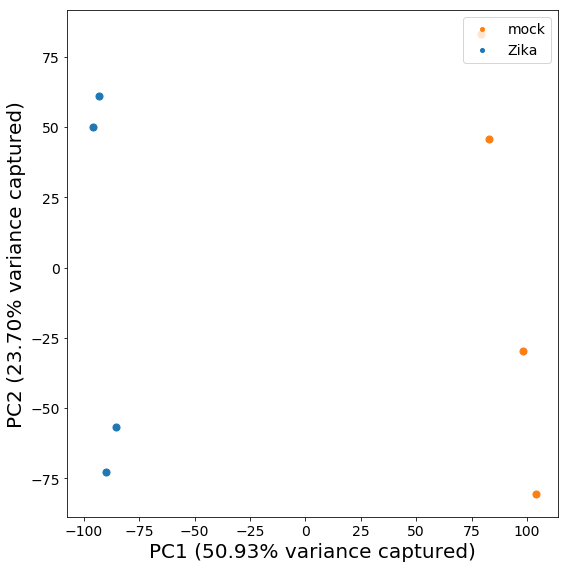

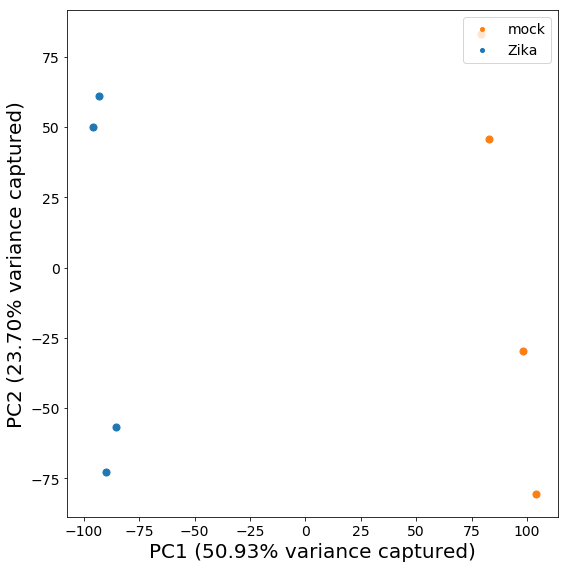

In [9]:
# plot PCA
%matplotlib inline
RNAseq.PCA_plot(expr_df.values, meta_df['infection_status'], 
         standardize=2, log=True, 
         show_text=False, sep=' ', legend_loc='upper right')

The PCA plot below is the same as above, except that we color the samples by platform (two Illumina sequencing machines used: [Illumina MiSeq](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GPL15520) for paired-end and [Illumina NextSeq 500](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GPL18573) for single-end). 

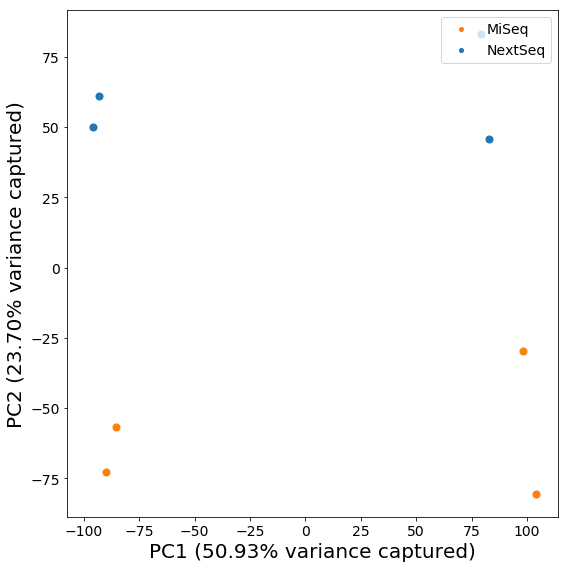

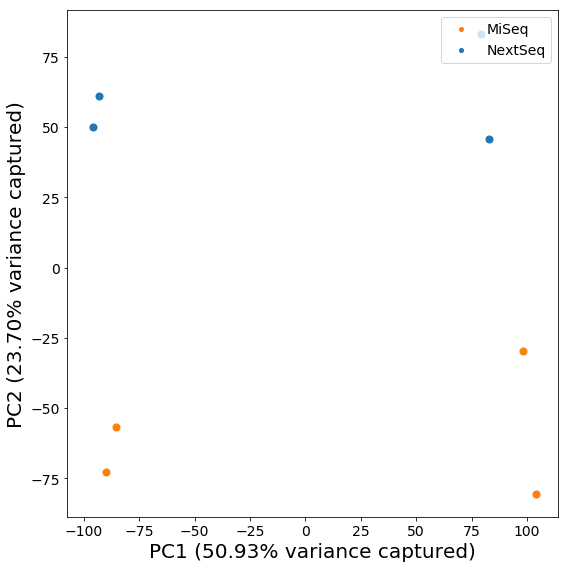

In [10]:
d_layout_platform = {'PAIRED': 'MiSeq', 'SINGLE': 'NextSeq 500'}
meta_df['platform'] = [d_layout_platform[l] for l in meta_df['LibraryLayout']]
RNAseq.PCA_plot(expr_df.values, meta_df['platform'], 
         standardize=2, log=True, 
         show_text=False, sep=' ', legend_loc='upper right')

We can also plot a 3D interactive PCA plot using [plotly](https://plot.ly/), which has a nice integration with Jupyter notebooks.

In [11]:
# Compute the coordinates of samples in the PCA space
variance_explained, pca_transformed = RNAseq.perform_PCA(expr_df.values, standardize=2, log=True)
# Bind x, y, z coordinates to meta_df
meta_df['x'] = pca_transformed[:,0]
meta_df['y'] = pca_transformed[:,1]
meta_df['z'] = pca_transformed[:,2]

In [24]:
import plotly
plotly.offline.init_notebook_mode() # To embed plots in the output cell of the notebook
import plotly.graph_objs as go

conditions = meta_df['infection_status'].unique().tolist()
platforms = meta_df['platform'].unique().tolist()
SYMBOLS = ['circle', 'square']
COLORS = RNAseq.COLORS10

data = [] # To collect all Scatter3d instances
for (condition, platform), meta_df_sub in meta_df.groupby(['infection_status', 'platform']):
    # Iteratate through samples grouped by condition and platform
    display_name = '%s, %s' % (condition, platform)
    # Initiate a Scatter3d instance for each group of samples specifying their coordinates
    # and displaying attributes including color, shape, size and etc.
    trace = go.Scatter3d(
        x=meta_df_sub['x'],
        y=meta_df_sub['y'],
        z=meta_df_sub['z'],
        text=meta_df_sub.index,
        mode='markers',
        marker=dict(
            size=10,
            color=COLORS[conditions.index(condition)], # Color by infection status
            symbol=SYMBOLS[platforms.index(platform)], # Shaped by sequencing platforms
            opacity=.8,
        ),
        name=display_name,
    )
    
    data.append(trace)

# Configs for layout and axes
layout=dict(height=1000, width=1000, 
            title='3D PCA plot for samples in Zika study',
            scene=dict(
                xaxis=dict(title='PC1 (%.2f%% variance)' % variance_explained[0]),
                yaxis=dict(title='PC2 (%.2f%% variance)' % variance_explained[1]),
                zaxis=dict(title='PC3 (%.2f%% variance)' % variance_explained[2])
               )
)
fig=dict(data=data, layout=layout)
plotly.offline.iplot(fig)

Alternatively, we can visualize the gene expression matrix using [Clustergrammer](http://amp.pharm.mssm.edu/clustergrammer/). Clustergrammer is a visualization tool that we developed to enable users and web-based applications to easily generate interactive and shareable clustergram-heatmap visualizations from a matrices of data. In the following code, we display a subset the expression matrix using genes with the largest variance. We then log transform and z-score center the expression matrix so that it has an average of zero, and a standard deviation of unity for each gene on the rows. We write the subset of expression matrix into a text file, and then use a HTTP `POST` of this file to the [API of Clustergrammer](http://amp.pharm.mssm.edu/clustergrammer/help#api). The API then responds with a URL to the interactive clustergram.

In [12]:
# Subset the expression DataFrame using top 800 genes with largest variance
variances = np.var(expr_df, axis=1)
srt_idx = variances.argsort()[::-1]
expr_df_sub = expr_df.iloc[srt_idx].iloc[:800]
print(expr_df_sub.shape)
expr_df_sub.head()

(800, 8)


SRR3191542   SRR3191543   SRR3191544   SRR3191545   SRR3194428  \
Unnamed: 0                                                                    
EEF1A1      7996.914844  7728.522697  7117.145710  6934.361849  4350.294882   
WSB1        4057.667309  4193.539404  1147.384503  1233.034685  4575.830939   
TUBA1A      5880.046645  6185.289214  5352.007639  5128.629843  4230.585532   
ACTG1       6064.652974  6467.303415  4865.145023  4719.835796  5997.922569   
MIAT        2962.422101  2976.053896  1473.119962  1449.869075  2821.714482   

             SRR3194429   SRR3194430   SRR3194431  
Unnamed: 0                                         
EEF1A1      4313.573623  3943.919005  3810.744906  
WSB1        4811.727247  1291.503911  1371.135167  
TUBA1A      4487.822687  3815.217178  3718.109637  
ACTG1       6337.756691  4703.434004  4683.201963  
MIAT        2869.276075  1420.125638  1365.302406

In [14]:
# Log transform and z-score standardize the data and write to a .txt file 
expr_df_sub.index.name=''
expr_df_sub = np.log1p(expr_df_sub)
expr_df_sub = expr_df_sub.apply(lambda x: (x-x.mean())/x.std(ddof=0), axis=1)
# prettify sample names
sample_names = ['-'.join([x, d_layout_platform[y], z]) for x,y,z in
                   zip(meta_df['infection_status'], meta_df['LibraryLayout'], expr_df_sub.columns)]
expr_df_sub.columns = sample_names
expr_df_sub_file = 'expression_matrix_top800_genes.txt'
expr_df_sub.to_csv(expr_df_sub_file, sep='\t')

In [25]:
# POST the expression matrix to Clustergrammer and get the URL
import requests, json
clustergrammer_url = 'http://amp.pharm.mssm.edu/clustergrammer/matrix_upload/'

r = requests.post(clustergrammer_url, files={'file': open(expr_df_sub_file, 'rb')})
link = r.text
display_link(link)

We can also display the result in this notebook using `<iframe>`

In [26]:
from IPython.display import IFrame
display(IFrame(link, width="1000", height="1000"))

<a id='out3'></a>
#### 3. Differential Expression
Now we are ready to identify the differentially expressed genes between the two sets of samples: control vs. treatment. We will achieve this using the [Characteristic Direction method](http://www.ncbi.nlm.nih.gov/pubmed/?term=24650281)<sup>[6](#ref6)</sup> that we developed and published in _BMC Bioinformatics_ in 2014.

An implementation in Python of the Characteristic Direction method can be downloaded and installed from here:
https://github.com/wangz10/geode.

In [13]:
import geode
d_platform_cd = {} # to top up/down genes
cd_results = pd.DataFrame(index=expr_df.index)

sample_classes = {}
for layout in meta_df['LibraryLayout'].unique():
    ## make sample_class 
    sample_class = np.zeros(expr_df.shape[1], dtype=np.int32)
    sample_class[meta_df['LibraryLayout'].values == layout] = 1
    sample_class[(meta_df['LibraryLayout'].values == layout) & 
                 (meta_df['infection_status'].values == 'Zika infected')] = 2
    platform = d_layout_platform[layout]
    sample_classes[platform] = sample_class

sample_classes['combined'] = sample_classes['MiSeq'] + sample_classes['NextSeq 500']
print(sample_classes)

for platform, sample_class in sample_classes.items():
    cd_res = geode.chdir(expr_df.values, sample_class, expr_df.index, 
                      gamma=.5, sort=False, calculate_sig=False)
    cd_coefs = np.array(list(map(lambda x:x[0], cd_res)))
    cd_results[platform] = cd_coefs
    
    # sort CD in by absolute values in descending order
    srt_idx = np.abs(cd_coefs).argsort()[::-1]
    cd_coefs = cd_coefs[srt_idx][:600]
    sorted_DEGs = expr_df.index[srt_idx][:600]
    # split up and down
    up_genes = dict(zip(sorted_DEGs[cd_coefs > 0], cd_coefs[cd_coefs > 0]))
    dn_genes = dict(zip(sorted_DEGs[cd_coefs < 0], cd_coefs[cd_coefs < 0]))
    d_platform_cd[platform+'-up'] = up_genes
    d_platform_cd[platform+'-dn'] = dn_genes

print(cd_results.head())

{'MiSeq': array([1, 1, 2, 2, 0, 0, 0, 0], dtype=int32), 'NextSeq 500': array([0, 0, 0, 0, 1, 1, 2, 2], dtype=int32), 'combined': array([1, 1, 2, 2, 1, 1, 2, 2], dtype=int32)}
                 MiSeq  NextSeq 500  combined
Unnamed: 0                                   
WASH7P       -0.000268    -0.000969 -0.000385
LOC729737    -0.000134    -0.000529 -0.000198
LOC100133331 -0.000755    -0.000849 -0.000701
MIR6723      -0.001514    -0.000954 -0.001068
LOC100288069 -0.000337    -0.000720 -0.000428


In [14]:
## Check the cosine distance between the two signatures
from scipy.spatial.distance import cosine
from itertools import combinations
for col1, col2 in combinations(cd_results.columns, 2):
    print(col1, col2, cosine(cd_results[col1], cd_results[col2]))


MiSeq NextSeq 500 0.0123447717754
MiSeq combined 0.00307475812027
NextSeq 500 combined 0.00457740495472


The following code generates links for gene set enrichment analysis with Enrichr<sup>[7](#ref7)</sup>. 

[Enrichr](http://amp.pharm.mssm.edu/Enrichr/) is gene set enrichment analysis tool that we developed. Enrichr compares the up or down gene sets computed here with over ~180,000 annotated gene sets belonging to ~90 gene set libraries covering pathway databases, ontologies, disease databases and more.

In [17]:
for key, d in d_platform_cd.items():    
    genes = d_platform_cd[key].keys()
    link = RNAseq.enrichr_link(genes, key)
    print(key)
    display_link(link)

MiSeq-up


MiSeq-dn


NextSeq 500-up


NextSeq 500-dn


combined-up


combined-dn


In [ ]:
## Generate Enrichr links for up/down genes in an Excel file with the gene sets.
enrichr_result_file = os.path.join(os.environ['WORKDIR'], 'Enrichr_links_CD600.xls')
RNAseq.dict2xls_with_vals(d_platform_cd, ['gene', 'CD coef'], enrichr_result_file)

In [ ]:
## Check the Enrichr results
enrichr_results = pd.read_excel(enrichr_result_file, sheetname=None)
print(enrichr_results.keys())

In [34]:
## Display the links in the pandas DataFrame
pd.set_option('display.max_colwidth', -1)
enrichr_results['Enrichr_links']['Link'] = enrichr_results['Enrichr_links']['Link']\
    .apply(lambda x: '<a href="%s">%s</a>' %(x, x))

HTML(enrichr_results['Enrichr_links'].to_html(escape=False))

From the results of enrichment analysis, we found that down-regulated genes after Zika infection are enriched from E2F4 targets and cell cycle genes.  

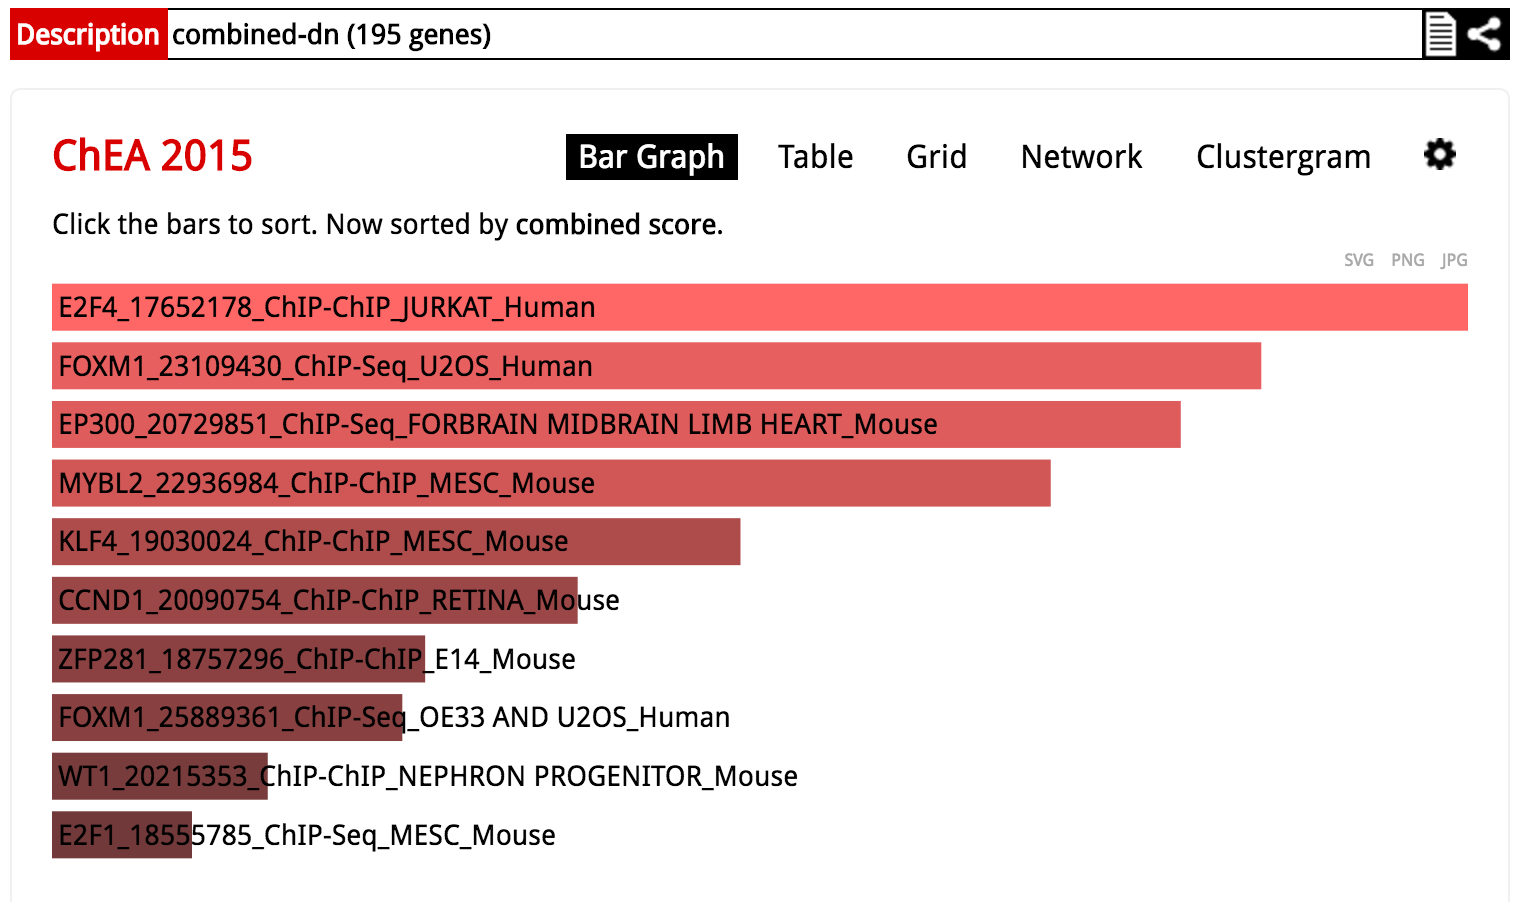

In [35]:
from IPython.display import Image
Image('img/combined-dn_ChEA.png', width='600')

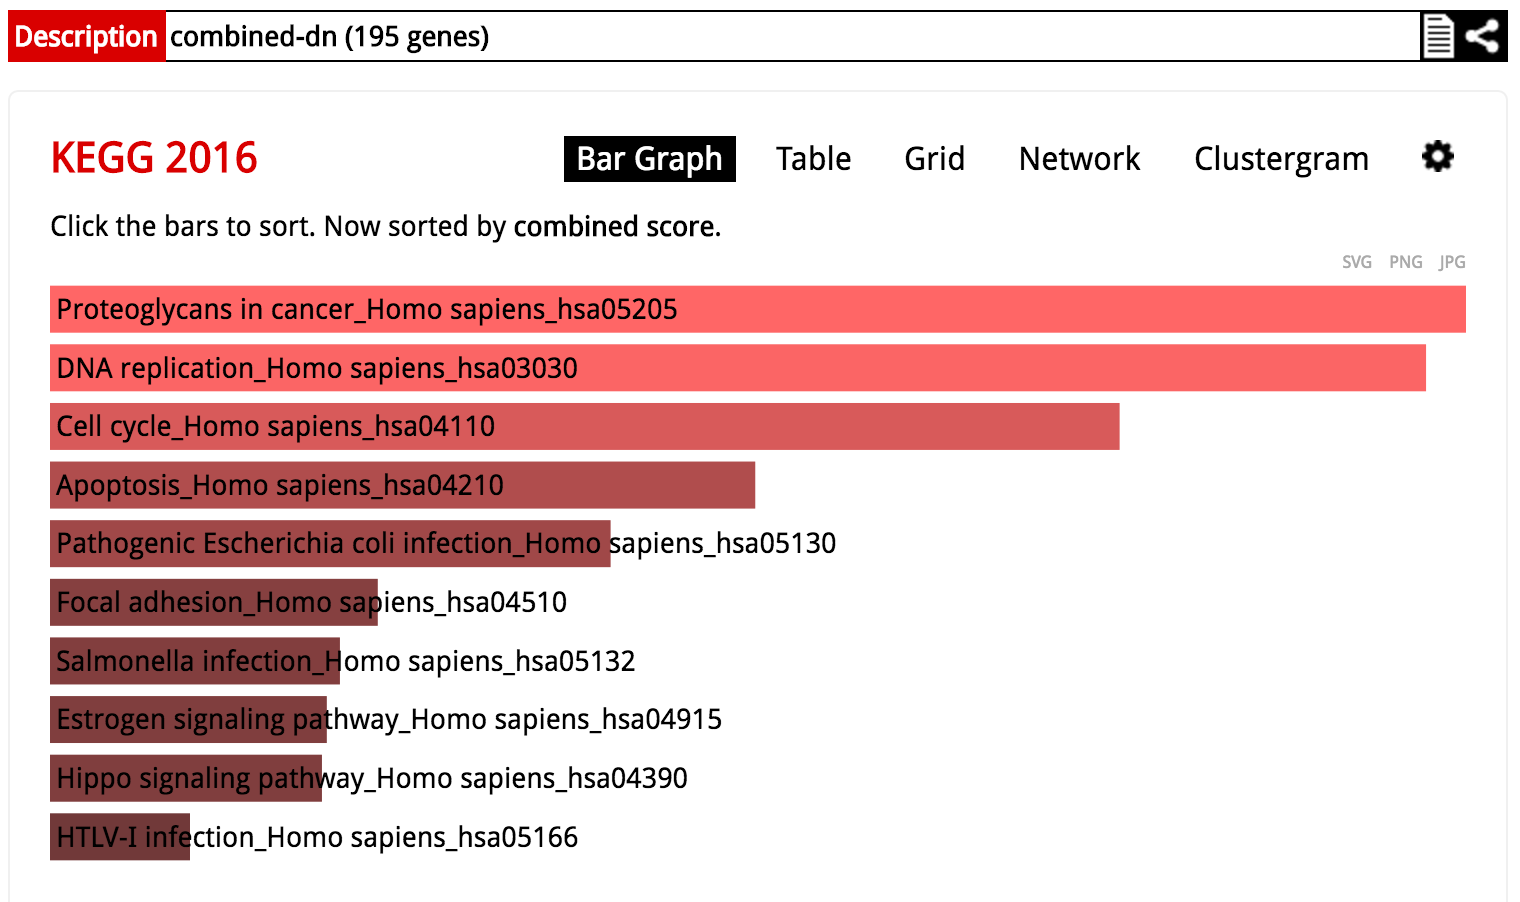

In [36]:
Image('img/combined-dn_KEGG.png', width='600')

We also found up-regulated genes after Zika infection are enriched for genes essential for normal brain morphology in mice.

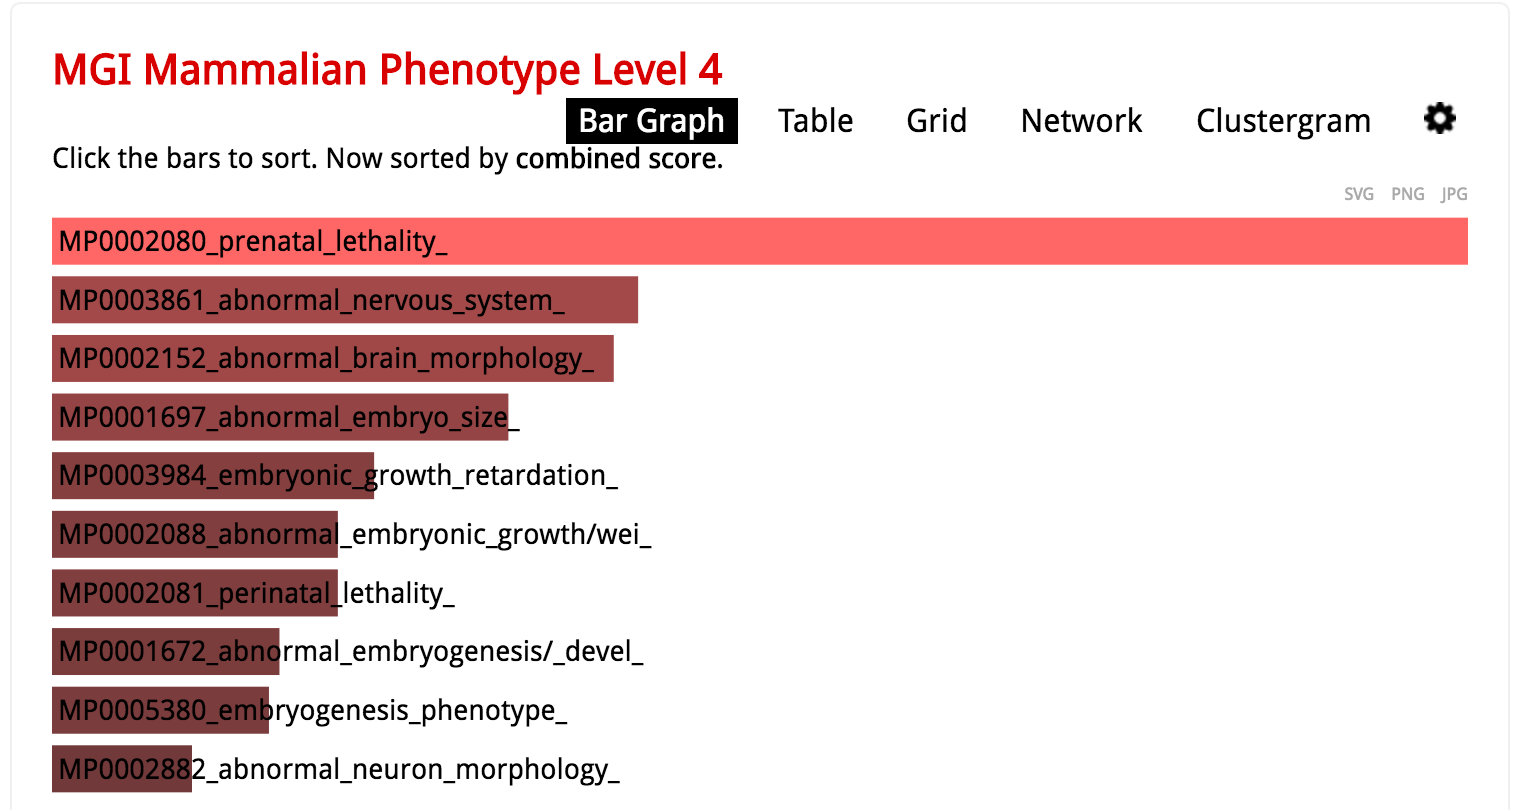

In [37]:
Image('img/combined-up_MGI4.png', width='600')

<a id='out4'></a>
### 4. Further Analysis
The above results are exciting because Zika infection of pregnant women would induce microcephaly in the fetus. We are interested in checking the overlapping genes between Zika induction and genes that are essential for brain morphology. 

To do that, we use the genes induced by Zika infection to enrich against the MGI Mammalian Phenotype level 4 gene set library using [Enrichr's API](http://amp.pharm.mssm.edu/Enrichr/help#api). The API responds with the top enriched terms and overlapping genes. We added hyperlinks to those overlapping genes to [Harmonizome](http://amp.pharm.mssm.edu/Harmonizome/), which is a integrated resource for human genes, proteins and their functional terms extracted and organized from over a hundred publicly available resources.

In [38]:
# Get Enrichr results for a specific gene set library from its API
gene_set_library = 'MGI_Mammalian_Phenotype_Level_4'
enrichr_results = RNAseq.enrichr_result(d_platform_cd['combined-up'], gmt=gene_set_library)

# Convert the enrichr_results object to a pandas DataFrame
enrichr_results = pd.DataFrame.from_records(enrichr_results[gene_set_library])
enrichr_results.columns = ['rank', 'terms', 'p-value', 'zscore', 'combined', 'Overlapping genes', 'q-value']
enrichr_results = enrichr_results.set_index('rank')

# Add hyperlinks for gene to Harmonizome
def gene_lists_to_links(genes):
    '''Convert a list of genes to a HTML string hyperlinking to Harmonizome'''
    html_str = ''
    for i, gene in enumerate(genes, start=1):
        html_str += '<a href="http://amp.pharm.mssm.edu/Harmonizome/gene/%s" target="_blank">%s</a>'%(gene, gene)
        if i % 6 == 0:
            html_str += '<br>'
        else:
            html_str += '<span>, </span>'
    return html_str

enrichr_results['Overlapping genes'] = enrichr_results['Overlapping genes'].apply(gene_lists_to_links)
# Visualize the DataFrame
HTML(enrichr_results.iloc[:4].to_html(escape=False, float_format=lambda x: '%.2e' % x, justify='left'))

Next we would like to identify small molecules that can either reverse or mimic ZIKV induced gene expression with the LINCS L1000 data.
For this we will utilize [L1000CDS2](http://amp.pharm.mssm.edu/L1000CDS2/#/index)<sup>[9](#ref9)</sup>, a small molecule gene expression signature search engine that we developed. 
L1000CDS2 contains gene expression signatures from ~30,000 small molecules profiled with the L1000 technology for the LINCS program. Users can search for small molecules that can potentially reverse or mimic their input gene expression signatures.

---

The following code posts the gene expression signatures induced by ZIKV infection to L1000CDS2 and prints out the resultant URLs. 

In [39]:
def post_to_cds2(genes, vals, name=None, aggravate=False):
    ## post CD signature to L1000CDS2 API and return a CDS2 url
    url = 'http://amp.pharm.mssm.edu/L1000CDS2/query'
    cds2_url = None

    data = {
        "genes": map(lambda x: x.upper(), genes), 
        "vals":  vals
        }
    config = {"aggravate":aggravate,"searchMethod":"CD","share":True,"combination":True,"db-version":"latest"}
    metadata = [{"key":"name","value": name}]

    payload = {"data":data,"config":config,"meta":metadata}
    headers = {'content-type':'application/json'}
    r = requests.post(url,data=json.dumps(payload),headers=headers)
    resCD = r.json()
    shareId = resCD['shareId']
    cds2_url = 'http://amp.pharm.mssm.edu/L1000CDS2/#/result/' + shareId
    return cds2_url

In [40]:
## get URL from L1000CDS2
for col in cd_results:
    res = cd_results[col].copy()
    srt_idx = np.abs(res).argsort()
    res = res[srt_idx]
    genes = res[:2000].index.tolist()
    vals = res[:2000].tolist()
    cds2_url_mimic = post_to_cds2(genes, vals, name=col, aggravate=True)
    print col, 'mimickers'
    display_link(cds2_url_mimic)
    cds2_url_reverse = post_to_cds2(genes, vals, name=col, aggravate=False)
    print col, 'reversers'
    display_link(cds2_url_reverse)    

NextSeq 500 mimickers


NextSeq 500 reversers


MiSeq mimickers


MiSeq reversers


combined mimickers


combined reversers


After examining the results from L1000CDS2 search, we have found several small molecules that are consistently highly ranked as potential mimickers and reversers of Zika virus infection signatures. They are shown below.

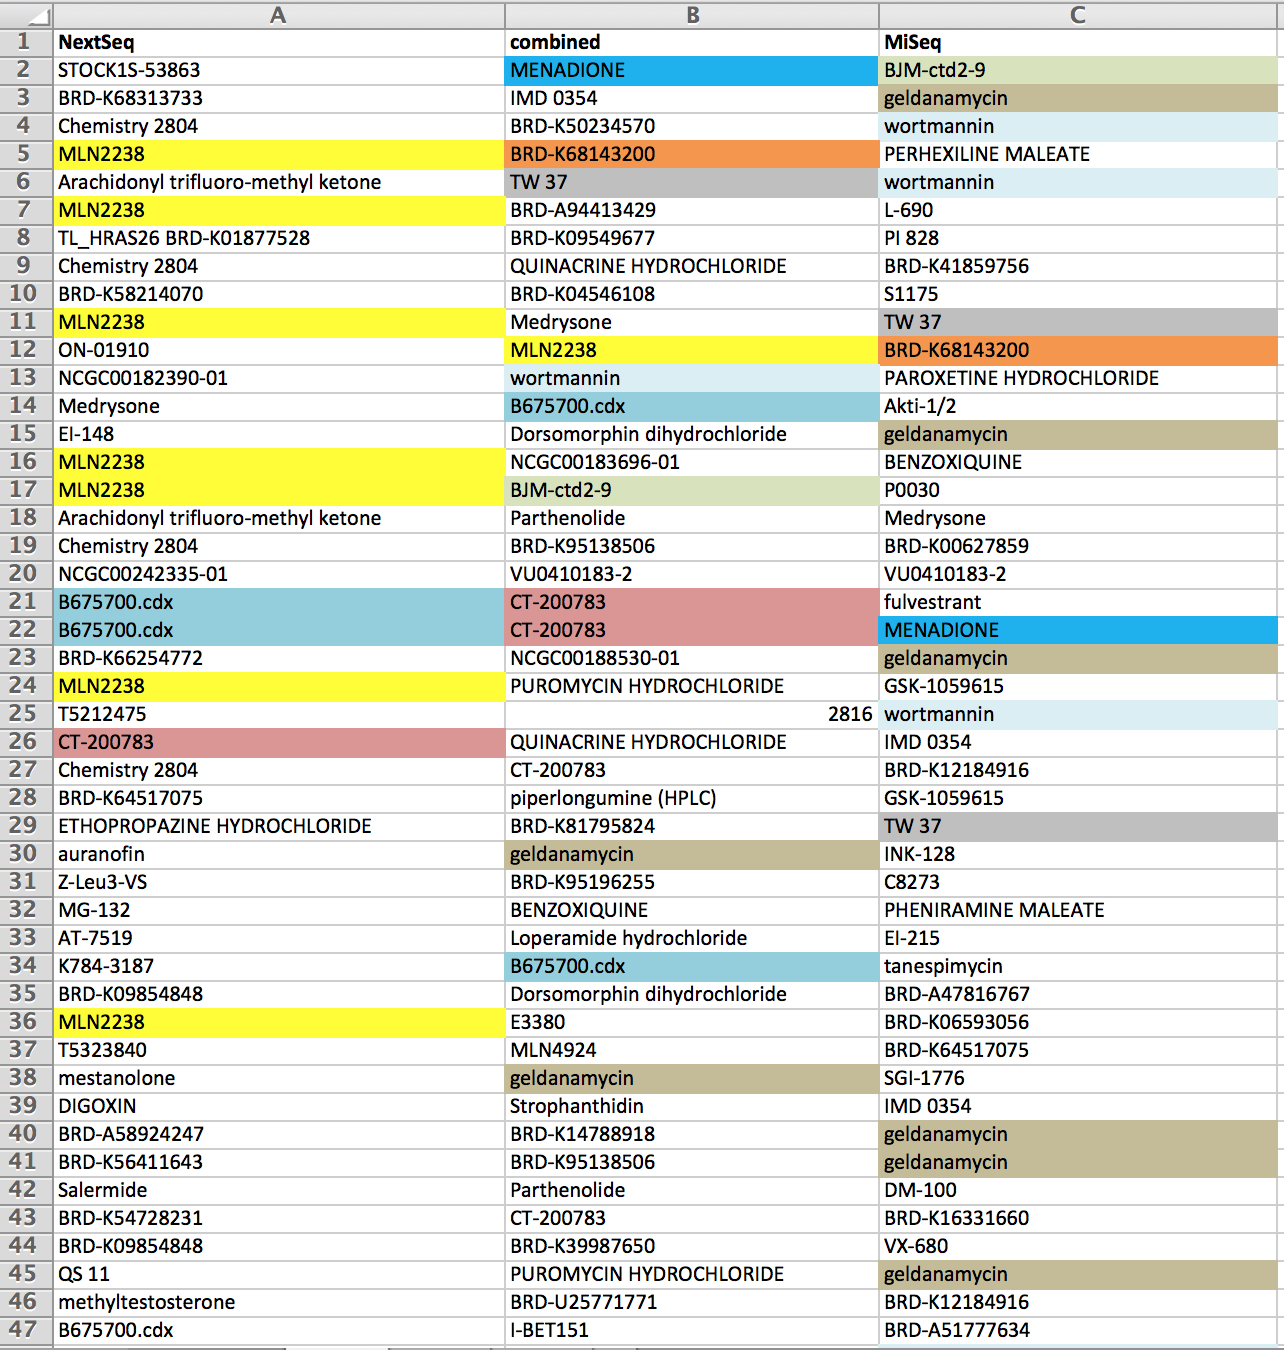

In [37]:
Image('img/zika-drug-mimickers.png', width='600')

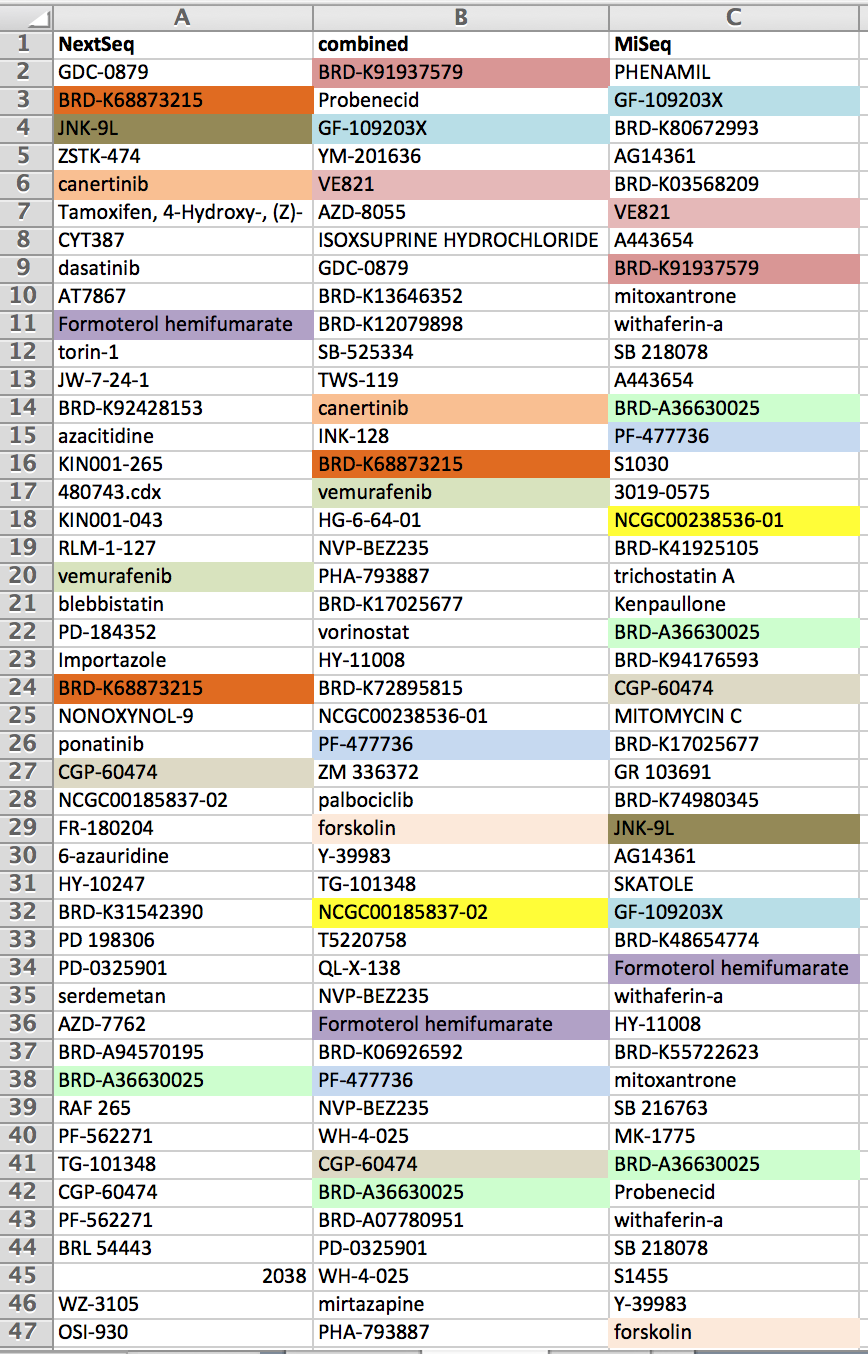

In [38]:
Image('img/zika-drug-reversers.png', width='600')

<a id='out5'></a>
### 5. Motivation for further work 

In summary, we have reproduced an open source RNA-seq processing pipeline that can be used to extract knowledge from any study that profiled gene expression using RNA-seq applied to mammalian cells, comparing two conditions. The advantage of providing the pipeline in the IPython notebook format is that it enables others to quickly reproduce the results with minimal overhead and potentially apply similar methodology for the analysis of other similar datasets. Advanced users can add, improve and customize the pipeline by forking it on GitHub. 

---
There is still a lot to be done...
![bioinfo](img/bioinf.png)

<a id='out6'></a>
### References
---
<a id='ref1'></a>
1. Wang Z. and Ma'ayan A. (2016a), [The IPython notebook for Zika-RNAseq Pipeline](http://nbviewer.jupyter.org/github/maayanlab/Zika-RNAseq-Pipeline/blob/master/Zika.ipynb); Accessed 2019, 16 May
<a id='ref2'></a>
2. Wang Z. and Ma'ayan A. (2016b), [Docker Image for Zika-RNAseq Pipeline](https://hub.docker.com/r/maayanlab/zika/); Accessed 2019, 16 May
<a id='ref3'></a>
3. Leinonen, R., Sugawara, H., Shumway, M., & International Nucleotide Sequence Database Collaboration. (2010). **The sequence read archive**. Nucleic acids research, 39(suppl_1), D19-D21. PMID: [21062823](https://www.ncbi.nlm.nih.gov/pubmed/21062823)
<a id='ref4'></a>
4. Andrews, S. (2010) **FastQC: A quality control tool for high throughput sequence data.** _Reference Source_.
<a id='ref5'></a>
5. Dobin, A., Davis, C.A., Schlesinger, F., Drenkow, J., Zaleski, C., Jha, S., Batut, P., Chaisson, M. and Gingeras, T.R. (2013) **STAR: ultrafast universal RNA-seq aligner.** _Bioinformatics_, 29, 15-21. PMID: [23104886](http://www.ncbi.nlm.nih.gov/pubmed/23104886)
<a id='ref6'></a>
6. Liao, Y., Smyth, G.K. and Shi, W. (2014) **featureCounts: an efficient general purpose program for assigning sequence reads to genomic features.** _Bioinformatics_, 30, 923-930. PMID: [24227677](http://www.ncbi.nlm.nih.gov/pubmed/24227677)
<a id='ref7'></a>
7. Robinson, M.D., McCarthy, D.J. and Smyth, G.K. (2010) **edgeR: a Bioconductor package for differential expression analysis of digital gene expression data.** _Bioinformatics_, 26, 139-140. PMID: [19910308](http://www.ncbi.nlm.nih.gov/pubmed/19910308)
